<a href="https://colab.research.google.com/github/trunghachi/AIFromZero/blob/master/contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contrastive Learning Tutorial in PyTorch with Point Clouds



## Installation / Setup

In [1]:
# We will use conda for easier installation of PyG
# If only using pip, it somehow takes forever to install on colab
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [1]:
# Install torch geometric for point-cloud layers
import torch
version = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"
try:
    import torch_geometric
except:
    !echo $version
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f $version
    import torch_geometric

https://data.pyg.org/whl/torch-2.2.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.4/943.4 kB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 29.2 MB/s eta 0:00:00
   ━━━━━

✋ **Note: You'll need to restart your runtime and execute the two cells again.** ✋

## Dataset

Goal:
- Self-Supervised Representation Learning of Shapes
- Can be used for downstream tasks like clustering, fine-tuning, outlier-detection, ...
- Pointcloud = Set of unconnected nodes --> PyG
- [ShapeNet Dataset](https://paperswithcode.com/dataset/shapenet) - we just use a subset of classes and act like we didn't have labels
- I select 5k data points as otherwise I run out of memory on Colab



In [1]:
from torch_geometric.datasets import ShapeNet
# Limit to 5000 samples, due to RAM restrictions
dataset = ShapeNet(root=".", categories=["Table", "Lamp", "Guitar", "Motorbike"]).shuffle()[:5000]
print("Number of Samples: ", len(dataset))
print("Sample: ", dataset[0])

Extracting ./shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Processing...
Done!


Number of Samples:  5000
Sample:  Data(x=[2834, 3], y=[2834], pos=[2834, 3], category=[1])


Attribute Name  | Description
-------------------|------------------
Pos       | Normalized positions as 3D coordinates
X       |  Normal vectors
Y       | Class label

In [17]:
dataset.category[100:120]

tensor([0, 0, 1, 2, 0, 2, 3, 0, 0, 2, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0])

In [2]:
dataset[0].pos

tensor([[ 0.0351,  0.1001, -0.2630],
        [ 0.0397,  0.0997, -0.2614],
        [ 0.1436,  0.0969, -0.2515],
        ...,
        [ 0.1676, -0.1000, -0.2939],
        [ 0.1759, -0.0733, -0.2844],
        [ 0.1830, -0.0889, -0.2792]])

Let's use plotly to inspect the data ...

In [3]:
#!pip install plotly --quiet
import plotly.express as px

def plot_3d_shape(shape):
    print("Number of data points: ", shape.x.shape[0])
    x = shape.pos[:, 0]
    y = shape.pos[:, 1]
    z = shape.pos[:, 2]
    fig = px.scatter_3d(x=x, y=y, z=z, opacity=0.3)
    fig.show()

# Pick a sample
sample_idx = 2
plot_3d_shape(dataset[sample_idx])

Number of data points:  2735


In [4]:
# Let's check the distribution of classes
cat_dict = {key: 0 for key in dataset.categories}
for datapoint in dataset: cat_dict[dataset.categories[datapoint.category.int()]]+=1
cat_dict

{'Table': 3407, 'Lamp': 995, 'Guitar': 485, 'Motorbike': 113}

## Data Preparation

- In some scenarios it makes sense to pre-compute the augmentations (for example if heavy computations are involved)
- This would require to store multiple Data Points in one Data Object, which is possible in PyTorch
- Here we will compute the augmentations on the fly and use the below transformations for this
- Later, for each data point we will need 2 augmentations (positive pair)
- What are good augmentations for Point Clouds?
    - Rotation (if the used layer is not rotation invariant)
    - Jittering (can be seen as adding noise to the coordinates)
    - Shifting / Shearing
    - ... many more




In [5]:
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# We're lucky and pytorch geometric helps us with pre-implemented transforms
# which can also be applied on the whole batch directly
augmentation = T.Compose([T.RandomJitter(0.03), T.RandomFlip(1), T.RandomShear(0.2)])

Let's have a look at some samples ...

In [6]:
# Original data point
sample = next(iter(data_loader))
plot_3d_shape(sample[0])

Number of data points:  2740


In [7]:
# Augmented data point
transformered = augmentation(sample)
plot_3d_shape(transformered[0])

Number of data points:  2740


## Model

- Different choices for Point Cloud Feature-Learning layers (PointNet, PointNet++, EdgeConv, PointTransformer, ...)
- In PyTorch geometric we find an implementation of DynamicEdgeConv
- It uses the parameter k to detect the nearest neighbors which form a subgraph
- If you have many points, you can also sample a subset
- In the paper they use 4 layers, here we just have 2
- Implementation is inspired by [this PyG example](https://github.com/pyg-team/pytorch_geometric/blob/a6e349621d4caf8b381fe58f8e57109b2d0947ed/examples/dgcnn_segmentation.py)
- We only apply augmentations during training






In [8]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool


class Model(torch.nn.Module):
    def __init__(self, k=20, aggr='max'):
        super().__init__()
        # Feature extraction
        self.conv1 = DynamicEdgeConv(MLP([2 * 3, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 128]), k, aggr)
        # Encoder head
        self.lin1 = Linear(128 + 64, 128)
        # Projection head (See explanation in SimCLRv2)
        self.mlp = MLP([128, 256, 32], norm=None)

    def forward(self, data, train=True):
        if train:
            # Get 2 augmentations of the batch
            augm_1 = augmentation(data)
            augm_2 = augmentation(data)

            # Extract properties
            pos_1, batch_1 = augm_1.pos, augm_1.batch
            pos_2, batch_2 = augm_2.pos, augm_2.batch

            # Get representations for first augmented view
            x1 = self.conv1(pos_1, batch_1)
            x2 = self.conv2(x1, batch_1)
            h_points_1 = self.lin1(torch.cat([x1, x2], dim=1))

            # Get representations for second augmented view
            x1 = self.conv1(pos_2, batch_2)
            x2 = self.conv2(x1, batch_2)
            h_points_2 = self.lin1(torch.cat([x1, x2], dim=1))

            # Global representation
            h_1 = global_max_pool(h_points_1, batch_1)
            h_2 = global_max_pool(h_points_2, batch_2)
        else:
            x1 = self.conv1(data.pos, data.batch)
            x2 = self.conv2(x1, data.batch)
            h_points = self.lin1(torch.cat([x1, x2], dim=1))
            return global_max_pool(h_points, data.batch)

        # Transformation for loss function
        compact_h_1 = self.mlp(h_1)
        compact_h_2 = self.mlp(h_2)
        return h_1, h_2, compact_h_1, compact_h_2

Possible improvement: Only pass once through model by stacking augmentations

## Training

- We use InfoNCE / NT-Xent Loss implemented in pytorch metric learning library
- Temperature allows to balance the similarity measure (make it more peaked)
- Typical values are around 0.1 / 0.2

In [9]:
# See https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#ntxentloss
!pip install pytorch-metric-learning -q

from pytorch_metric_learning.losses import NTXentLoss
loss_func = NTXentLoss(temperature=0.10)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Use a large batch size (might lead to RAM issues)
# Free Colab Version has ~ 12 GB of RAM
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


- No test dataset, as the evaluation can be done "downstream"
- The compact representations go into the loss function
- During test time no augmentations are applied and we can use the output representations

In [11]:
import tqdm

def train():
    model.train()
    total_loss = 0
    for _, data in enumerate(tqdm.tqdm(data_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        # Get data representations
        h_1, h_2, compact_h_1, compact_h_2 = model(data)
        # Prepare for loss
        embeddings = torch.cat((compact_h_1, compact_h_2))
        # The same index corresponds to a positive pair
        indices = torch.arange(0, compact_h_1.size(0), device=compact_h_2.device)
        labels = torch.cat((indices, indices))
        loss = loss_func(embeddings, labels)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(dataset)

for epoch in range(1, 4):
    loss = train()
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')
    scheduler.step()

100%|██████████| 157/157 [06:17<00:00,  2.40s/it]


Epoch 001, Loss: 1.6085


100%|██████████| 157/157 [06:18<00:00,  2.41s/it]


Epoch 002, Loss: 0.8045


100%|██████████| 157/157 [06:17<00:00,  2.41s/it]

Epoch 003, Loss: 0.5695


## Evaluation of the Embeddings

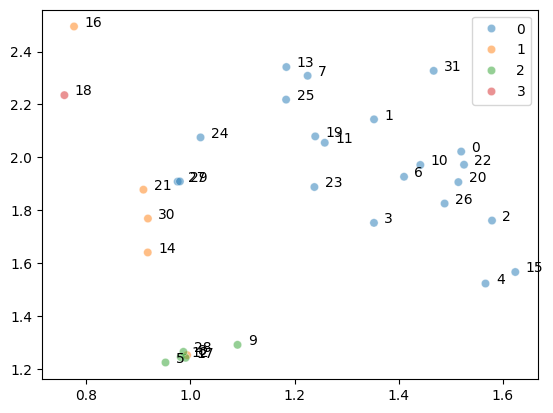

In [12]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Get sample batch
sample = next(iter(data_loader))

# Get representations
h = model(sample.to(device), train=False)
h = h.cpu().detach()
labels = sample.category.cpu().detach().numpy()

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(h.numpy())

# Plot
ax = sns.scatterplot(x=h_embedded[:,0], y=h_embedded[:,1], hue=labels,
                    alpha=0.5, palette="tab10")

# Add labels to be able to identify the data points
annotations = list(range(len(h_embedded[:,0])))

def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(int(point['val'])))

label_points(pd.Series(h_embedded[:,0]),
            pd.Series(h_embedded[:,1]),
            pd.Series(annotations),
            plt.gca())

Let's find the most similar and most different data points ...

[Source](https://stackoverflow.com/questions/50411191/how-to-compute-the-cosine-similarity-in-pytorch-for-all-rows-in-a-matrix-with-re)

In [13]:
import numpy as np

def sim_matrix(a, b, eps=1e-8):
    """
    Eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

similarity = sim_matrix(h, h)
max_indices = torch.topk(similarity, k=2)[1][:, 1]
max_vals  = torch.topk(similarity, k=2)[0][:, 1]

# Select index
idx = 17
similar_idx = max_indices[idx]
print(f"Most similar data point in the embedding space for {idx} is {similar_idx}")

Most similar data point in the embedding space for 17 is 12


Categories are: "Table", "Lamp", "Guitar", "Motorbike", "Skateboard"

**Note**: This is only based on the data in the current batch!

In [14]:
plot_3d_shape(sample[idx].cpu())

Number of data points:  2331


In [15]:
plot_3d_shape(sample[similar_idx].cpu())

Number of data points:  2296


This confirms that our embedding space has a proper arrangement and that our contrastive loss separated different entities successfully.